100%|██████████| 9.46M/9.46M [00:00<00:00, 128MB/s]


Episode 0, Loss: 1.4972, Acc: 0.8400
Episode 200, Loss: 0.9836, Acc: 0.9200
Episode 400, Loss: 0.9608, Acc: 0.9600
Episode 600, Loss: 0.9531, Acc: 0.9600
Episode 800, Loss: 0.9755, Acc: 1.0000
Episode 1000, Loss: 0.9962, Acc: 1.0000
Episode 1200, Loss: 0.9124, Acc: 1.0000
Episode 1400, Loss: 0.9408, Acc: 0.9600
Episode 1600, Loss: 0.9945, Acc: 0.9200
Episode 1800, Loss: 0.9758, Acc: 0.9600
Episode 2000, Loss: 0.9273, Acc: 1.0000
Episode 2200, Loss: 0.9054, Acc: 1.0000
Episode 2400, Loss: 0.9050, Acc: 1.0000
Episode 2600, Loss: 0.9318, Acc: 0.9600
Episode 2800, Loss: 0.9233, Acc: 1.0000
Test Accuracy: 99.04%


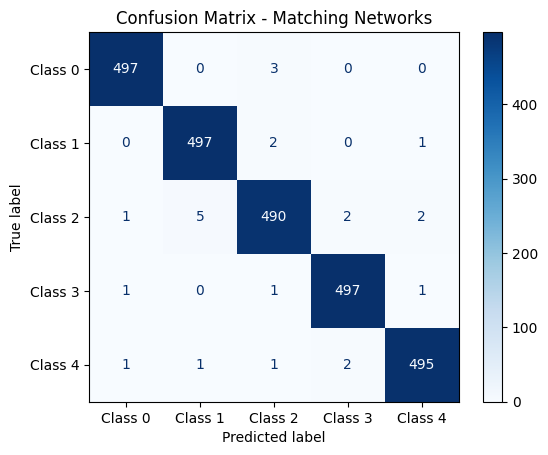

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import Omniglot
from torchvision import transforms
import random
from collections import defaultdict
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Encoder cải tiến
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

# Euclidean distance
def euclidean_dist(a, b):
    n = a.size(0)
    m = b.size(0)
    a = a.unsqueeze(1).expand(n, m, -1)
    b = b.unsqueeze(0).expand(n, m, -1)
    return ((a - b) ** 2).sum(2)

# Matching Networks
class MatchingNet(nn.Module):
    def __init__(self, encoder):
        super(MatchingNet, self).__init__()
        self.encoder = encoder

    def forward(self, support_x, support_y, query_x, n_way):
        support_embed = self.encoder(support_x)
        query_embed = self.encoder(query_x)

        distances = euclidean_dist(query_embed, support_embed)
        one_hot = F.one_hot(support_y, num_classes=n_way).float()

        attention = F.softmax(-distances, dim=1)
        preds = torch.matmul(attention, one_hot)

        return preds

# Dữ liệu Omniglot
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1.0 - x)  # đảo màu trắng-đen
])
dataset = Omniglot(root='./data', background=True, download=True, transform=transform)

data_by_class = defaultdict(list)
for img, label in dataset:
    data_by_class[label].append(img)

# Tạo episode 5-way 5-shot
def create_episode(n_way=5, k_shot=5, q_query=5):
    selected_classes = random.sample(list(data_by_class.keys()), n_way)
    support, query = [], []
    for i, cls in enumerate(selected_classes):
        samples = random.sample(data_by_class[cls], k_shot + q_query)
        support += [(img, i) for img in samples[:k_shot]]
        query += [(img, i) for img in samples[k_shot:]]
    return support, query

# Huấn luyện MatchingNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder().to(device)
model = MatchingNet(encoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for episode in range(3000):
    support, query = create_episode()
    support_x, support_y = zip(*support)
    query_x, query_y = zip(*query)

    support_x = torch.stack(support_x).to(device)
    support_y = torch.tensor(support_y).to(device)
    query_x = torch.stack(query_x).to(device)
    query_y = torch.tensor(query_y).to(device)

    preds = model(support_x, support_y, query_x, n_way=5)
    loss = F.cross_entropy(preds, query_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if episode % 200 == 0:
        acc = (preds.argmax(1) == query_y).float().mean().item()
        print(f"Episode {episode}, Loss: {loss.item():.4f}, Acc: {acc:.4f}")

# Đánh giá
model.eval()
all_preds, all_labels = [], []
for _ in range(100):
    support, query = create_episode()
    support_x, support_y = zip(*support)
    query_x, query_y = zip(*query)

    support_x = torch.stack(support_x).to(device)
    support_y = torch.tensor(support_y).to(device)
    query_x = torch.stack(query_x).to(device)
    query_y = torch.tensor(query_y).to(device)

    preds = model(support_x, support_y, query_x, n_way=5)
    all_preds.extend(preds.argmax(1).cpu().numpy())
    all_labels.extend(query_y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc*100:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(5)])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Matching Networks")
plt.show()


In [ ]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(5)])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Matching Networks")
plt.show()

NameError: name 'confusion_matrix' is not defined